In [1]:
import sys
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

WORK_DIR = Path(Path.cwd()).parent
sys.path.append(str(WORK_DIR))
from src.datasets import FPHA_PAF
from src.utils import parse_data_cfg, IMG, TSN, FPHA, DATA_DIR, PAF
from src.models import get_model
from src.datasets import get_dataset, get_dataloader

In [3]:
exp_fold = 'exp3'
cfgname = 'fpha_paf_base'
cfg = parse_data_cfg(WORK_DIR/'data_cfg'/exp_fold/(cfgname + '.cfg'))
data_split = 'test'
epoch = 200
exp_dir = cfg['exp_dir']
split_set = cfg[data_split + '_set']

# Dataloader

In [3]:
dataset_kwargs = {'split_set': split_set}
dataset   = get_dataset(cfg, dataset_kwargs)
sampler   = None
shuffle   = cfg['shuffle']
kwargs = {'batch_size'  :   int(cfg['batch_size']),
          'shuffle'     :   shuffle,
          'num_workers' :   int(cfg['num_workers']),
          'pin_memory'  :   True}
data_loader = get_dataloader(dataset, sampler, kwargs)

In [4]:
img_b, heatmap_b, _, uvd_b = next(iter(data_loader))
img_b = img_b.cpu().numpy()
heatmap_b = heatmap_b.cpu().numpy()
uvd_b = uvd_b.cpu().numpy()
img_b = img_b.transpose((0, 2, 3, 1))
img_b = IMG.scale_img_255(img_b)

heatmap_b = heatmap_b.transpose((0, 2, 3, 1))

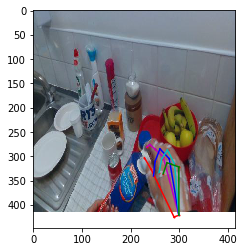

In [5]:
idx = 0
uvd = uvd_b[idx]
heatmap = heatmap_b[idx]
img = img_b[idx]

fig, ax = plt.subplots()
ax.imshow(img)
FPHA.visualize_joints_2d(ax, uvd[FPHA.REORDER_IDX])

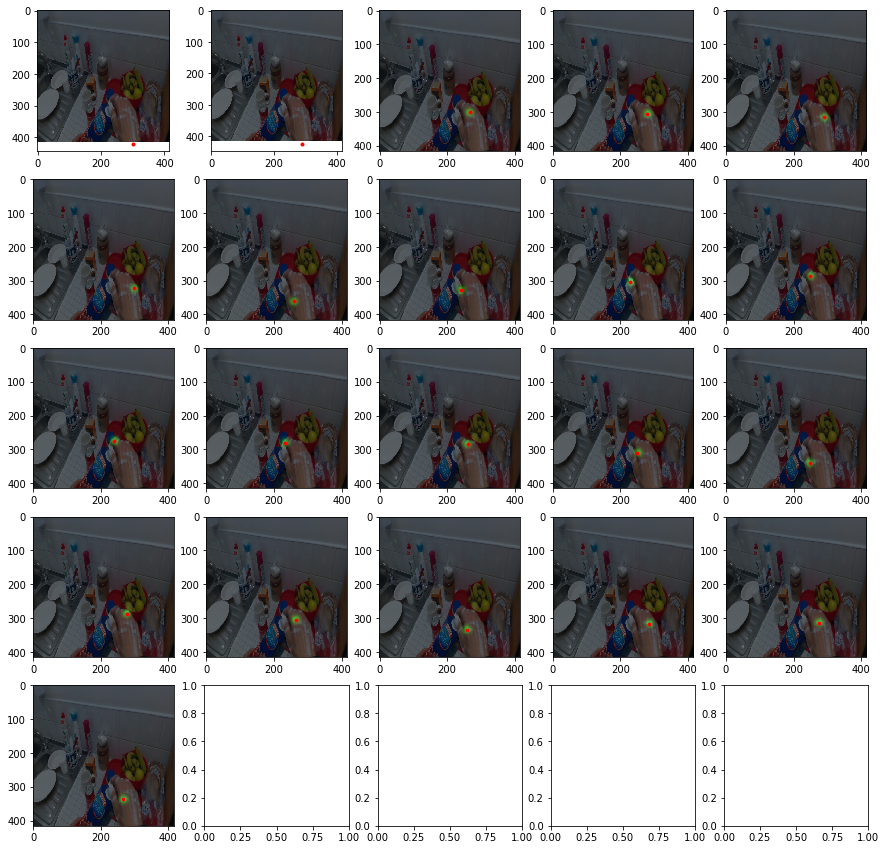

In [6]:
heatmap = heatmap.astype('float32')
fig, ax = plt.subplots(5, 5, figsize=(15, 15))
for i in range(5):
    for j in range(5):
        k = np.ravel_multi_index((i, j), (5, 5))
        if k >= heatmap.shape[2]:
            break        
        show_scoremap = cv2.cvtColor(heatmap[:, :, k], cv2.COLOR_GRAY2RGB)
        show_scoremap = cv2.normalize(show_scoremap, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_8UC3)
        show_scoremap[:, :, 0] = 0
        show_scoremap[:, :, 2] = 0
        show_scoremap = IMG.resize_img(show_scoremap, (img.shape[1], img.shape[0]))
        show = 0.5*show_scoremap + 0.5*img
    
        ax[i, j].imshow(show.astype('uint32'))
        ax[i, j].plot(uvd[k, 0], uvd[k, 1], 'r.')
#         FPHA.visualize_joints_2d(ax[i, j], uvd[FPHA.REORDER_IDX])

In [7]:
# show_img = FPHA.visualize_paf(img, IMG.resize_img(paf, (img.shape[1], img.shape[0])))
# print(show_img.shape)
# fig, ax = plt.subplots(figsize=(15, 15))
# ax.imshow(show_img)

# Evaluation

In [4]:
root = Path(DATA_DIR)/'First_Person_Action_Benchmark'
with open(root/(split_set + '_img.txt'), 'r') as f:
    img_path = f.read().splitlines()
xyz_gt = np.loadtxt(root/(split_set + '_xyz.txt'))
xyz_gt = np.reshape(xyz_gt, (-1, 21, 3))
uvd_gt = FPHA.xyz2uvd_color(xyz_gt)

pred_file = os.path.join(DATA_DIR, exp_dir, 'predict_{}_{}_uvd.txt'.format(epoch, data_split))
pred_uvd = np.reshape(np.loadtxt(pred_file), (-1, 21, 2))
pred_uvd = IMG.scale_points_WH(pred_uvd, (256, 256), (1920, 1080))
# pred_uvd[..., 2] *= 1000
# pred_xyz = FPHA.uvd2xyz_color(pred_uvd)

Subject_1/close_juice_bottle/1/color/color_0067.jpeg


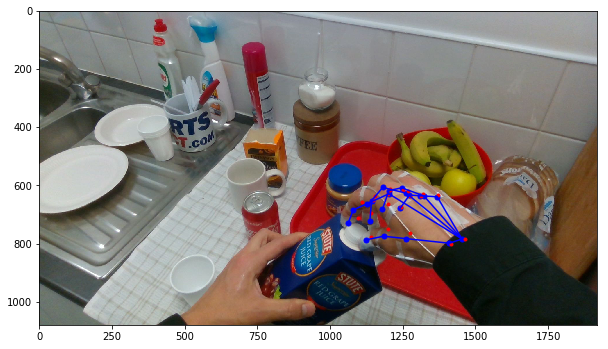

In [10]:
idx = 30000  
print(img_path[idx])
cur_gt = uvd_gt[idx].copy()
cur_pred = pred_uvd[idx].copy()
# cur_gt = IMG.scale_points_WH(cur_gt, (1920, 1080), (256, 256))

vis = np.ones(21)
for i, j in enumerate(cur_gt):
    if j[0] <= 0 or j[0] >= FPHA.ORI_WIDTH or \
        j[1] <=0 or j[1] >= FPHA.ORI_HEIGHT:
            vis[i] = 0
for i, j in enumerate(cur_pred):
    if np.sum(j) == 0:
        vis[i] = 0
vis = vis.astype('bool')    

vis_pred = np.ones(21)
for i, j in enumerate(cur_pred):
    if np.sum(j) == 0:
        vis_pred[i] = 0
vis_pred = vis_pred.astype('bool')    

img = Image.open(root/'Video_files'/img_path[idx])
img = np.asarray(img)
# img = IMG.resize_img(img, (256, 256))
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img)

ax.plot(cur_gt[:, 0][vis], cur_gt[:, 1][vis], 'b.', ms=10)
ax.plot(cur_pred[:, 0][vis], cur_pred[:, 1][vis], 'r.')
FPHA.visualize_joints_2d(ax, cur_gt[FPHA.REORDER_IDX], c='b')
FPHA.visualize_joints_2d(ax, cur_pred[FPHA.REORDER_IDX], c='r')

In [6]:
error = []
error_index = []
for index, (pred, uvd) in enumerate(zip(pred_uvd, uvd_gt[:, :, :2])):
#     print(i, FPHA.mean_L2_error(uvd, pred))
    vis = np.ones(21)
    for i, j in enumerate(uvd):
        if j[0] <= 0 or j[0] >= FPHA.ORI_WIDTH or \
            j[1] <=0 or j[1] >= FPHA.ORI_HEIGHT:
                vis[i] = 0
    for i, j in enumerate(pred):
        if np.sum(j) == 0:
            vis[i] = 0
    vis = vis.astype('bool')
    if(np.sum(vis) == 0):
        continue
    error_index.append(index)
    error.append(FPHA.mean_L2_error(uvd[vis], pred[vis]))
error = np.asarray(error)
print('%s UVD mean_l2_error: ' %data_split, np.mean(error))
min_error_idx = np.argmin(error)
max_error_idx = np.argmax(error)
print('Best Pose id:', error_index[min_error_idx], 'uvd_error:', error[min_error_idx])
print('Worst Pose id:', error_index[max_error_idx], 'uvd_error:', error[max_error_idx])
for idx in np.argsort(error):
    print(error_index[idx])

test UVD mean_l2_error:  37.170268318600655
Best Pose id: 2596 uvd_error: 5.117378131100471
Worst Pose id: 37819 uvd_error: 1160.6515474281016
2596
593
9042
1654
1623
1650
2614
594
1252
2597
32275
1604
38997
29200
1655
1272
1609
29183
1309
29177
2920
598
595
1615
1271
1349
9039
1651
1476
1248
1501
1652
1656
1636
1503
1587
1230
599
1490
19851
1247
1598
1607
1635
1603
46951
1762
29201
1243
20223
32953
3363
1625
9041
2192
1597
1347
46952
1634
38983
1765
1253
29187
46975
1342
35592
1761
29189
1350
1769
1588
28999
38948
1627
46903
1267
38495
29214
29175
2925
1763
1601
38478
29211
29199
36398
19852
1344
1491
2595
30872
591
38973
20201
46974
616
606
1613
38493
1614
1842
10473
38980
19864
1348
592
1602
46196
36601
3424
29185
1241
1770
47001
1600
1266
45957
231
1502
1764
615
10928
44557
38494
1653
724
1586
19983
3436
30876
3440
20545
1486
7861
1595
38985
1213
1488
1638
46950
1500
29203
45580
46499
30871
29202
14760
9036
617
1632
38942
1599
1590
20793
1556
2431
19984
2921
1640
1368
1948
2194
371

43581
45840
1520
2882
49837
1960
2706
20016
10335
35910
28596
45969
20182
49821
34296
2544
19997
1980
36313
733
19504
1887
1572
46931
42001
2291
36319
28984
20363
51727
36613
13803
11157
36535
35371
19925
44142
8750
28832
100
14828
1568
3300
28898
35572
1967
10985
21514
2114
38473
21589
11309
28414
35376
20619
36391
35700
23493
20019
43126
27747
4662
45954
35699
51729
734
1391
10481
43450
49818
24268
36908
3630
35940
36383
23583
44143
21631
13996
42846
3589
3624
35894
30013
10835
46831
4829
51288
10546
20224
36529
22288
769
3669
3030
20669
44199
4807
44506
35471
20524
19811
36335
22203
42337
37394
42454
6650
13972
13857
20491
38341
8595
27702
1921
45968
38277
34319
10902
8610
2343
11284
2386
20200
1942
10816
35430
42447
13904
1117
37301
35338
43395
42783
46932
516
42779
21342
21045
8983
28852
8777
44643
1700
11979
20509
442
26534
4766
12720
41725
22385
14747
46729
6652
37065
655
29288
2189
19902
8785
42500
41728
658
44382
14755
23302
436
28415
20181
28419
42558
20083
39449
6466
19631
3

12853
4592
44516
11839
10338
11080
5442
19501
27666
10736
6651
22030
2647
12239
8629
12256
44005
38345
4772
12844
2182
21165
47099
44239
20938
28411
46046
21571
779
13763
30009
36737
13089
16333
36557
20992
20617
3303
675
47580
35360
46658
27113
13741
15059
41936
10896
29236
42248
11971
38357
46019
51760
43435
28763
46261
22960
922
30514
44448
29503
4306
45828
36653
5139
15239
10
37929
30812
2078
9422
3040
2504
46891
44007
26470
49895
2724
42562
19794
19638
12867
34375
43427
8546
1954
6801
30461
19905
11970
10769
9417
29970
28578
35533
44497
42645
45721
11134
46757
20442
13850
28639
44469
44949
23991
34683
5751
2153
46714
19520
8522
46813
15699
5115
4590
4556
6467
46827
10413
2080
36350
27813
42703
10149
503
27814
3329
46961
38305
43964
28869
14753
50101
43846
22450
34591
1805
33487
27857
21197
8992
36323
29960
8908
39451
20443
4825
23993
10367
21361
45010
36283
23499
8299
901
20439
21148
10255
27829
28594
12571
8936
10768
42619
50188
18501
35487
1726
17697
38514
35167
44332
35434
3721

34886
46528
34765
4332
29562
44586
8406
46548
29333
43267
22386
20612
27839
23511
47623
34874
32974
1662
34369
36927
35304
46544
21466
1161
20960
22119
35435
14350
5883
49341
7017
39853
12942
38320
36702
35535
44886
22002
15694
43950
16351
37958
20290
35117
1174
1706
21318
23450
946
26252
14243
276
24959
22355
3507
43600
8375
21532
28275
6628
50114
28566
36248
47447
45732
9368
21111
10396
42902
47383
11091
42389
3743
38309
7022
3714
8461
4196
1119
42216
6617
21742
47021
16332
34636
42331
10373
46717
30827
29564
38035
49783
13941
46639
37200
2160
16113
1935
30950
46670
37309
42299
13952
43605
24265
2862
42760
13009
273
12799
23454
23410
8653
1677
29252
43398
16252
22700
41675
22744
36495
34938
44201
3577
21265
49960
15331
29925
35628
23666
23101
35189
37371
23445
34511
24429
13081
36444
29325
35443
21359
21110
35415
38400
8331
18049
34862
32967
10358
263
44374
37389
3044
11448
12994
24271
5729
27204
50120
36941
46014
10688
22660
13020
17280
38214
22646
24961
35188
23121
12735
802
23943


19948
18024
8682
7026
44368
5310
45349
4191
46315
28311
23313
15616
6244
1406
36851
4207
35287
29640
19064
14249
5036
23065
17759
14347
33491
21271
35241
34662
30157
22022
15497
22329
20453
29272
4339
27770
37695
16203
8452
15362
49781
1742
43602
50184
12334
11560
22594
19067
21180
28427
14331
28751
1167
6494
50149
2497
20287
24153
2312
4375
30056
10226
22702
2229
23418
45330
17176
42154
41770
18234
23021
7025
35118
12472
46604
45009
46012
37687
11785
48128
28341
19950
50134
978
29418
2014
12832
21074
39531
21474
36086
21120
38137
1182
37345
34122
37719
1173
30841
33885
28404
38202
49851
44073
36065
24830
9967
13475
13223
30597
29250
33493
42723
17695
38666
23563
49964
39694
29499
23327
18739
40453
9393
35004
40227
20852
34641
41991
35739
16389
15260
45051
28718
15415
24194
23424
36102
9993
12455
51004
27861
44067
42853
28935
17452
1074
20972
27944
1676
12240
15287
49306
23437
19808
40457
20718
4217
43219
24945
30531
35184
49303
28281
14213
18774
47294
21656
23375
46647
38102
45656
541

2059
38125
24260
24247
47921
50052
34856
38237
4189
47481
40271
11922
11368
47293
33612
29938
47141
24248
44089
43630
12603
46558
33901
11589
43789
25772
33310
44042
31223
42188
24246
3783
46471
12643
16694
23763
24593
20377
18223
15540
4392
37791
9710
8250
35273
9538
45356
16213
14122
12606
45005
21662
9330
45258
10046
11832
22419
30678
15689
5193
13341
16674
43091
33437
35268
31887
23317
23087
2330
35353
5856
13133
39729
47310
14245
29467
42666
15768
25086
35622
14231
42050
24473
28653
11087
29400
9980
24787
7810
47291
46268
4646
2984
50122
16274
11047
5371
36195
2901
27529
24396
4952
16370
16729
36635
23632
24364
39534
11958
41835
37949
5376
9481
21649
40175
43192
23059
45500
39960
30130
37326
25210
50073
4599
10077
23343
29799
29152
40164
31264
12408
13690
18813
21812
16378
28609
47332
13131
19956
34906
38658
50086
21985
29641
33109
33016
41034
51294
39078
29083
13129
1118
9084
18875
33855
40463
12341
28493
30478
29322
8906
48755
18856
27914
15820
2818
47924
39579
26608
18032
2255


47356
41714
35254
7831
8671
47014
18186
16572
48020
24084
22924
17446
41779
35349
38796
9327
43836
18213
17544
19578
40739
22092
29733
40135
17158
5976
25169
40246
39530
15793
14426
29655
28562
52028
3498
21992
11207
47279
43199
5864
11599
8195
48371
7821
48068
17289
21289
48996
38788
41025
12090
15803
45674
7475
4240
7636
15909
30897
49056
29760
18941
12039
16752
30481
5216
30
18763
16672
33018
33080
30739
39992
11711
3064
5272
48566
17592
18969
42913
17604
7034
5789
3055
43912
44051
16367
11591
17057
34878
13660
12436
1924
44040
42399
23989
25216
36194
34421
14304
4714
48548
35068
31237
39570
16763
14324
48572
25251
22521
40253
31518
33842
4087
16745
14238
38914
15545
40120
24684
23854
48620
48451
51840
15910
4125
38420
23018
17071
7815
16111
49069
48289
11458
4981
13152
32277
16742
7812
9474
24632
23802
50147
40077
4413
3914
49480
41948
23861
24691
31263
29801
32278
47157
36505
19959
26007
15310
21291
6716
42424
11956
42878
6751
5787
49945
3234
43055
25447
48086
9536
7820
24177
1860

31533
37742
12183
45221
20673
37737
8563
27507
12750
39334
14640
32552
33940
51772
3008
4097
40339
19076
4602
25500
39561
34849
15139
41654
25882
42090
26159
21887
7378
5392
37783
50659
5829
6008
40169
4965
5674
45231
47756
5355
40311
34434
27515
26409
43008
6331
13066
7785
45204
46150
38872
27785
40273
48864
37648
39706
30974
47549
11575
6094
47348
31071
6845
26547
12983
51545
31950
51781
6328
38738
26455
17649
31400
37460
35408
22664
17548
46805
51841
38855
38697
23656
34439
38542
9901
40277
19075
39217
17672
22503
30738
29078
22100
14391
28305
9532
2487
19446
43703
17678
13585
12027
25731
24559
20650
31360
34736
11812
23219
6414
39874
43362
33771
30540
43746
17425
39018
8803
33338
17348
16067
39659
33398
29058
38701
28635
16093
39861
23205
2529
49449
13420
31783
30616
30286
31122
6344
27314
40274
50026
17381
38724
991
33435
9855
4045
17266
44092
16977
15751
5004
27635
4927
6348
31945
15723
49709
48325
49105
15847
11894
5011
7635
40655
34032
24485
31836
50010
22066
17486
27452
7390
3

24935
41138
19389
48543
27376
14880
34891
47176
35835
9825
24898
32724
37816
38070
2855
32667
48088
8096
43733
31055
50255
11650
5778
31167
9496
40104
25139
40056
48284
40038
48814
44661
31638
51892
39715
46136
5919
50790
17479
15837
32588
13299
18999
39359
16038
3753
19010
47345
38213
18144
40293
37745
3991
9881
15129
16538
40364
25870
41209
18101
48660
13295
50749
39326
9149
46406
47940
45203
26115
18439
6002
8881
27177
39254
33762
4484
5924
41409
47936
5670
50380
17975
18365
40087
8839
12111
39084
37751
39362
42811
41183
25794
15503
31624
50744
38770
44677
24909
48305
40808
42999
38068
40685
27878
33600
4983
18011
5526
15011
17236
33508
19198
48029
45545
31095
41133
46434
40727
39352
6033
31475
25465
40090
50735
41428
2095
51766
32563
25819
34256
21933
23196
47914
39208
41378
34262
11511
40193
39703
14493
6141
33862
24085
23986
9245
32333
41780
39130
39935
6409
17539
17819
39568
31277
40429
21808
22894
25604
26869
26125
7418
28544
31815
8856
21700
47999
25954
41957
21283
24758
4713


7616
31707
22101
32918
19253
14689
16472
48912
18353
41466
15440
51312
39167
7596
31037
18402
48846
9740
30707
32182
31393
50329
9320
36151
50570
50554
32397
50599
30248
16447
6926
50651
49222
16544
6890
44708
47989
31868
15577
26802
4904
19237
50366
48732
31869
17762
20268
26177
49533
31933
34083
14600
49198
7202
38887
48728
6961
8024
26246
45628
1747
32405
9818
51158
51424
31713
41200
51314
49258
16437
11668
16320
48926
49111
6895
37608
9819
48196
47967
41102
24390
49195
33521
37266
29992
32295
31686
6880
40571
34233
48923
49108
41426
32374
25058
6914
7068
27575
41115
50512
41597
47837
48894
7929
47973
15888
29545
41078
26148
48301
32700
50215
7601
6977
8016
51575
32172
9105
5500
49624
25451
14601
33342
32733
15640
39053
41002
39009
33738
16516
33556
6693
25637
40391
24921
18302
5498
30297
37861
32390
1923
42095
27146
50459
51343
24860
12131
48934
13052
31667
15469
14039
28533
24651
23821
43640
7151
8292
18626
50397
45887
25666
25581
45283
48292
50633
49536
45060
47904
28073
17930
48

31878
48260
29722
51645
19469
41653
51958
19148
24120
51622
51621
45180
48257
19025
51959
19145
31319
31866
51665
19322
45189
50046
51663
37492
14910
19156
25616
11687
45146
51614
7113
14942
48274
51657
48100
45535
45187
31312
33216
45527
19152
7187
45164
42130
21922
49587
19149
48590
48591
6579
51656
51957
45179
19159
51570
45149
50043
51612
7246
31873
32686
45541
45533
37493
48101
19468
18375
50839
24104
44866
19348
51915
6584
31439
19229
51659
48141
19147
48256
48518
31386
14913
51655
45161
45134
6580
33227
18404
51652
17598
43755
48258
45524
31313
37494
29779
51623
51610
31384
14912
49586
31435
21892
15880
31309
51620
19216
50979
51653
45107
31497
7244
31383
19151
45539
26091
45537
26099
51960
48517
19165
31314
31440
31502
42111
18370
48255
19465
42136
31495
14911
31501
31356
48511
45525
19460
31441
45538
45536
50045
31442
31311
33224
7112
50638
34263
18385
48179
51578
48616
40896
31877
34774
31448
42135
51900
33217
33223
31702
51651
49568
43758
31317
7261
7260
50601
31385
34775
25

# Workspace

In [8]:
ws_heatmap = IMG.resize_img(heatmap, (img.shape[1], img.shape[0])) 

joint_list_per_joint_type = PAF.NMS(ws_heatmap, img.shape[0]/float(ws_heatmap.shape[0]))

In [9]:
joint_list = np.array([tuple(peak) + (joint_type,) for joint_type, joint_peaks in enumerate(joint_list_per_joint_type) for peak in joint_peaks])

joints = np.zeros((21, 2))
for j in joint_list:
    joints[int(j[-1])] = j[:2]

In [10]:
joints = []
for j in joint_list_per_joint_type:
    if len(j) > 0:
        j = j[0]
        joints.append((j[0], j[1]))
joints = np.asarray(joints)

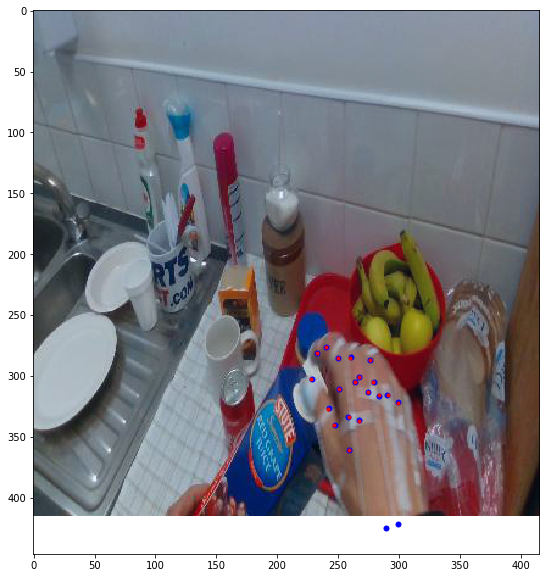

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img)
ax.plot(uvd[:, 0], uvd[:, 1], 'b.', ms=10)
ax.plot(joints[:, 0], joints[:, 1], 'r.')